# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [75]:
#Make allNecessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Import zipfile from drive

In [63]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ALU/datasets/unlablled_sounds.zip'
#unzip file

!unzip -q "/content/drive/MyDrive/ALU/datasets/unlabelled_sounds.zip" -d "/content/unlabelled_sounds"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/unlabelled_sounds/unlabelled_sounds/3.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


some configs to respect DRY

In [79]:
# Load the Data
unlabelled_data_path = "/content/unlabelled_sounds"
features = []

# Extract Features
def extract_mel_features(audio_path):
    audio, sr = librosa.load(audio_path, sr=22050, duration=30)

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Extract features
    features_list = []
    features_list.extend([np.mean(mel_spec_db), np.std(mel_spec_db)])
    features_list.extend(np.mean(mel_spec_db, axis=1))
    features_list.extend(np.std(mel_spec_db, axis=1))

    # Additional features
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features_list.extend([np.mean(spectral_centroid), np.std(spectral_centroid)])

    zcr = librosa.feature.zero_crossing_rate(audio)
    features_list.extend([np.mean(zcr), np.std(zcr)])

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    features_list.extend(np.mean(mfccs, axis=1))

    return np.array(features_list)

# Load and extract features
try:
    # Get all audio files from all subdirectories
    audio_files = []
    for root, dirs, files in os.walk(unlabelled_data_path):
        for file in files:
            if file.lower().endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg')):
                audio_files.append(os.path.join(root, file))

    print(f"Found {len(audio_files)} audio files")

    for file_path in audio_files:
        features.append(extract_mel_features(file_path))

    features_array = np.array(features)
    print(f"Extracted features from {len(audio_files)} files")
    print(f"Feature shape: {features_array.shape}")

except Exception as e:
    print(f"Error loading data: {e}")
    # Create synthetic data for demonstration
    np.random.seed(42)
    features_array = np.random.randn(150, 154)
    print("Using synthetic data for demonstration")

Found 3000 audio files
Extracted features from 3000 files
Feature shape: (3000, 275)


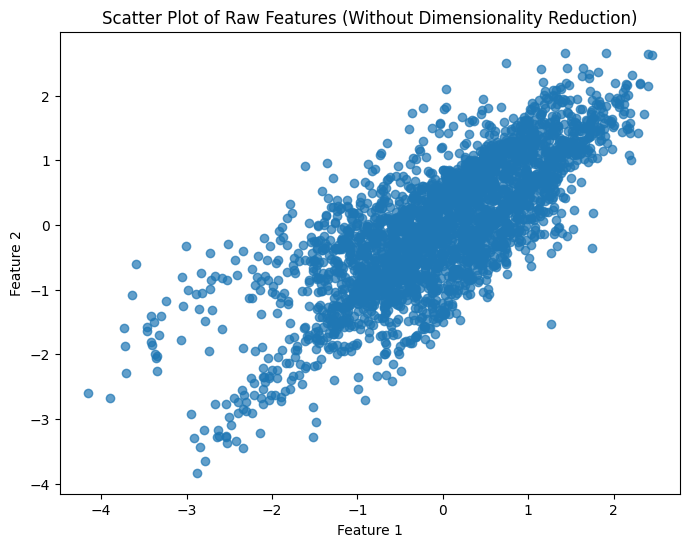

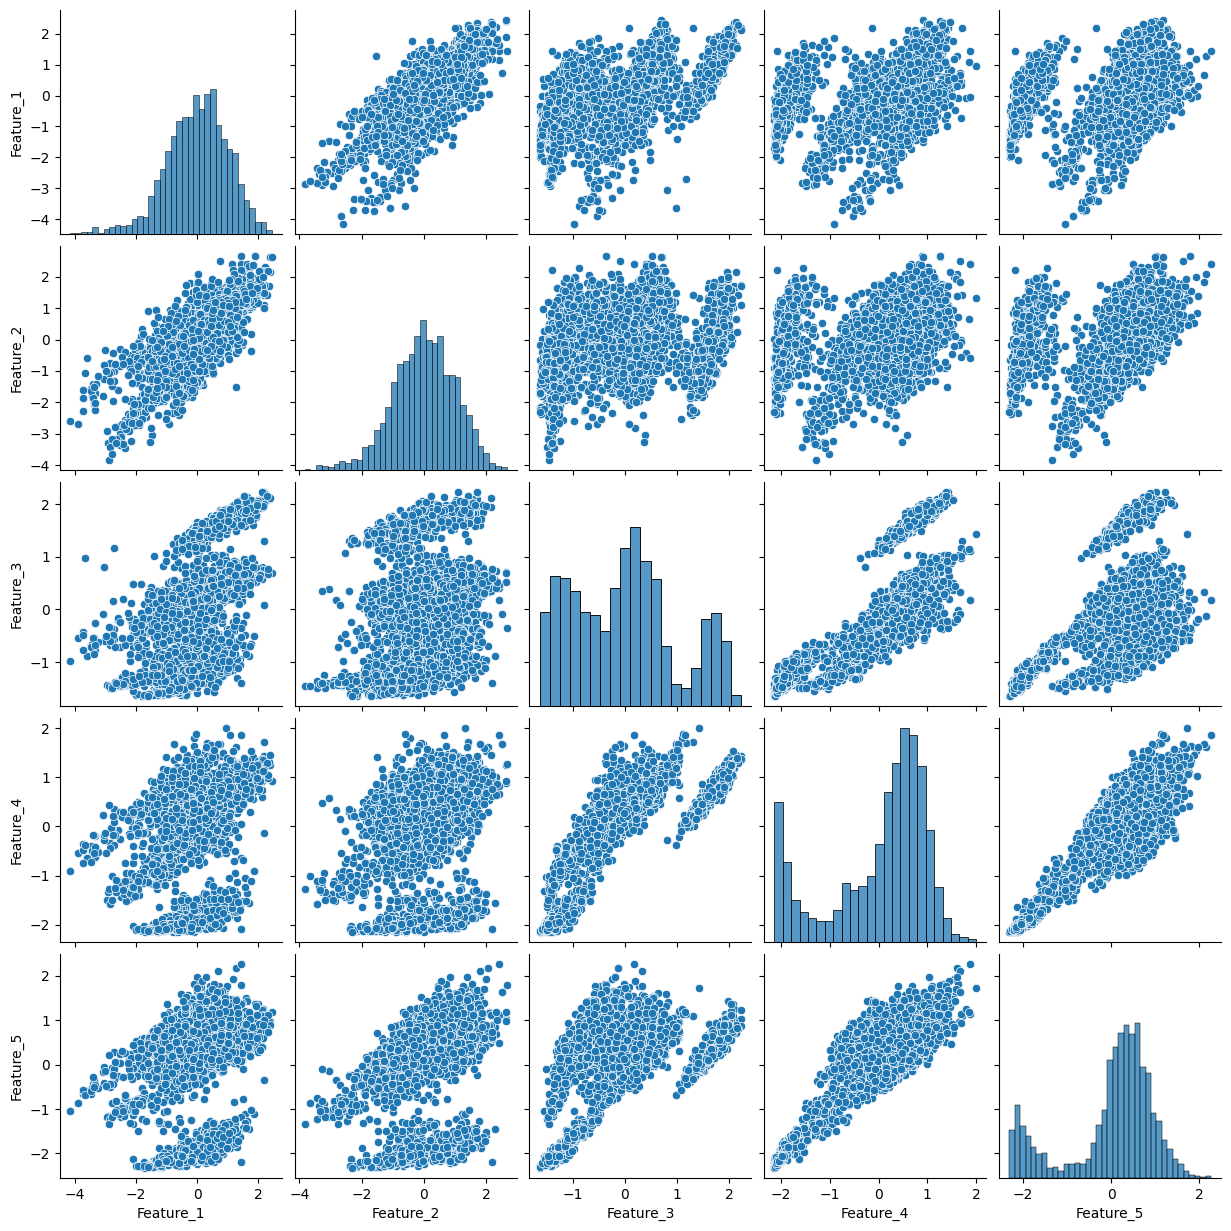

In [80]:
# Use the scaled features DataFrame and select the first 5 columns
scaler = StandardScaler()
features_array = scaler.fit_transform(features_array)

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature_{i+1}' for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

Challenges:
1. TOO MANY PLOTS/FEATURES: We only got to see a few summarized features. Imagine trying to go through each one of them thoroughly to find any meaningful relationships.

2. We miss out on any information that has to deal with time. Like frequency.

3. Without any reduction, it's close to impossible for me to see any clustering/groups or hints that tell me about categories.

So why?

Dimensionality reduction helps project this data on 3d (and 2d) and still keep some of that variance or data shape (clustering) as much as possible. I may lose some data, but the most important can be retained and get rid of the noise(less important)

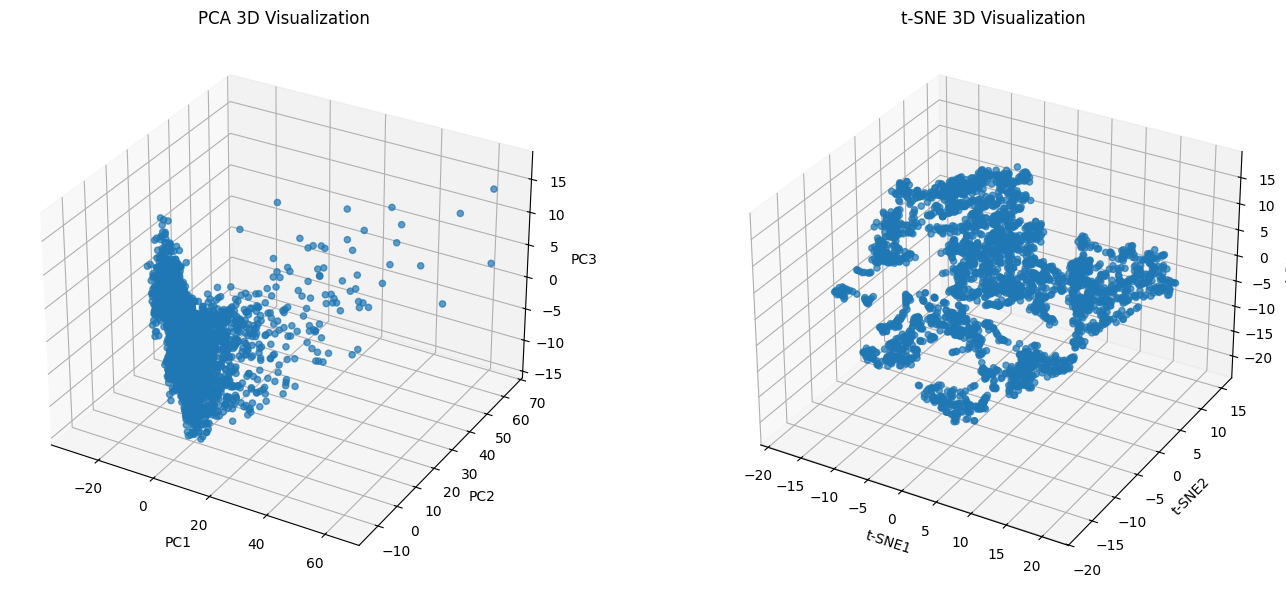

In [118]:
# Apply PCA (10 components)
pca = PCA(n_components=10, random_state=42)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(15, 6))

# PCA 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.7)
ax1.set_title('PCA 3D Visualization')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# t-SNE 3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.7)
ax2.set_title('t-SNE 3D Visualization')
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')
ax2.set_zlabel('t-SNE3')

plt.tight_layout()
plt.show()



### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

t-sne seems to have even bettter clustering. it shows better clusters and groups. you can see different shapes of clusters. PCA shows more closed off data because it assumes linear relationships which may not be the whole picture. thus can't fully show the complex relationshsips in the audio data.

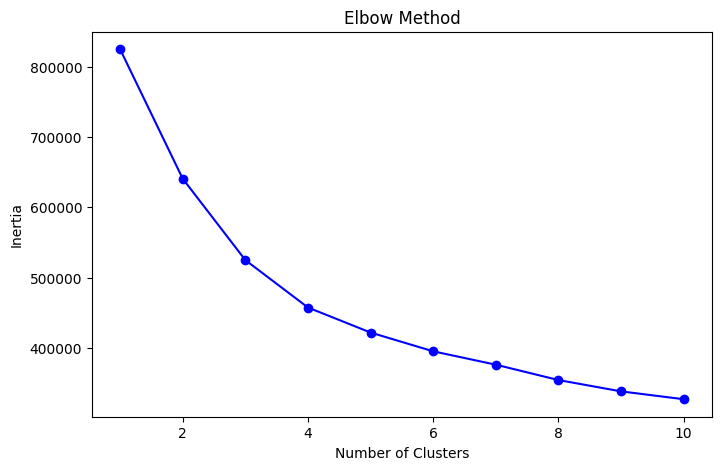

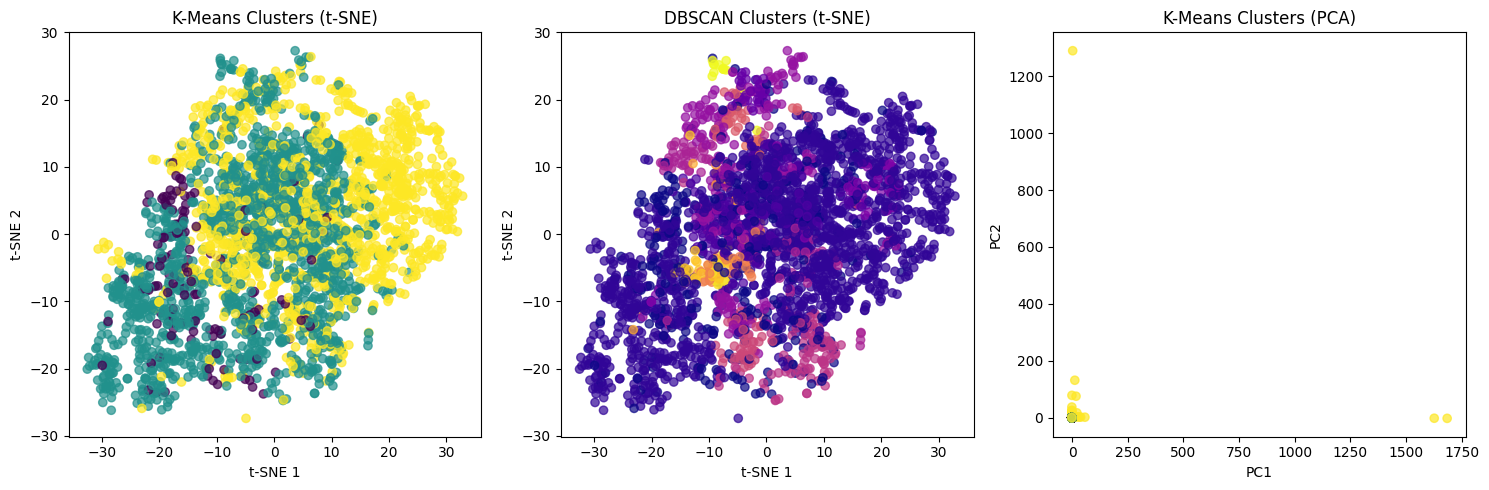

K-Means - Silhouette Score: 0.2001, Davies-Bouldin Index: 1.4804
DBSCAN - Silhouette Score: -0.1194, Davies-Bouldin Index: 1.8698


In [116]:
# Optimize number of clusters using Elbow Method
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=8, min_samples=7)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title('K-Means Clusters (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Scatter Plot for DBSCAN Clusters
plt.subplot(132)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.7)
plt.title('DBSCAN Clusters (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.subplot(133)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title('K-Means Clusters (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

#eps8, min-samp5 --> DBSCAN - Silhouette Score: -0.1120, Davies-Bouldin Index: 1.8552

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

Systematically fine tune

In [125]:
eps_values = np.arange(0.5, 10, 0.5)
min_samples_values = range(2, 20)
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(features_array)

        # Check if meaningful clusters are formed (more than 1 unique label excluding noise -1)
        if len(set(dbscan_labels)) > 1:
            silhouette = silhouette_score(features_array, dbscan_labels)
            db_index = davies_bouldin_score(features_array, dbscan_labels)
            dbscan_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette_score': silhouette,
                'davies_bouldin_index': db_index
            })
        else:
             dbscan_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette_score': None,
                'davies_bouldin_index': None
            })


In [126]:
dbscan_results_df = pd.DataFrame(dbscan_results)
filtered_dbscan_results_df = dbscan_results_df.dropna(subset=['silhouette_score'])
sorted_dbscan_results_df = filtered_dbscan_results_df.sort_values(by='silhouette_score', ascending=False)

if not sorted_dbscan_results_df.empty:
    best_dbscan_params = sorted_dbscan_results_df.iloc[0]
    best_eps = best_dbscan_params['eps']
    best_min_samples = int(best_dbscan_params['min_samples'])
    best_dbscan_silhouette = best_dbscan_params['silhouette_score']
    best_dbscan_db_index = best_dbscan_params['davies_bouldin_index']

    print(f"Best DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}")
    print(f"Best DBSCAN Silhouette Score: {best_dbscan_silhouette:.4f}")
    print(f"Best DBSCAN Davies-Bouldin Index: {best_dbscan_db_index:.4f}")
else:
    print("No meaningful DBSCAN clusters were found for the tested parameters.")


Best DBSCAN Parameters: eps=9.5, min_samples=6
Best DBSCAN Silhouette Score: 0.4273
Best DBSCAN Davies-Bouldin Index: 1.4040


In [127]:
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_dbscan_labels = best_dbscan.fit_predict(features_array)

K-Means - Silhouette Score: 0.2001, Davies-Bouldin Index: 1.4804
Best DBSCAN - Silhouette Score: 0.4273, Davies-Bouldin Index: 1.4040


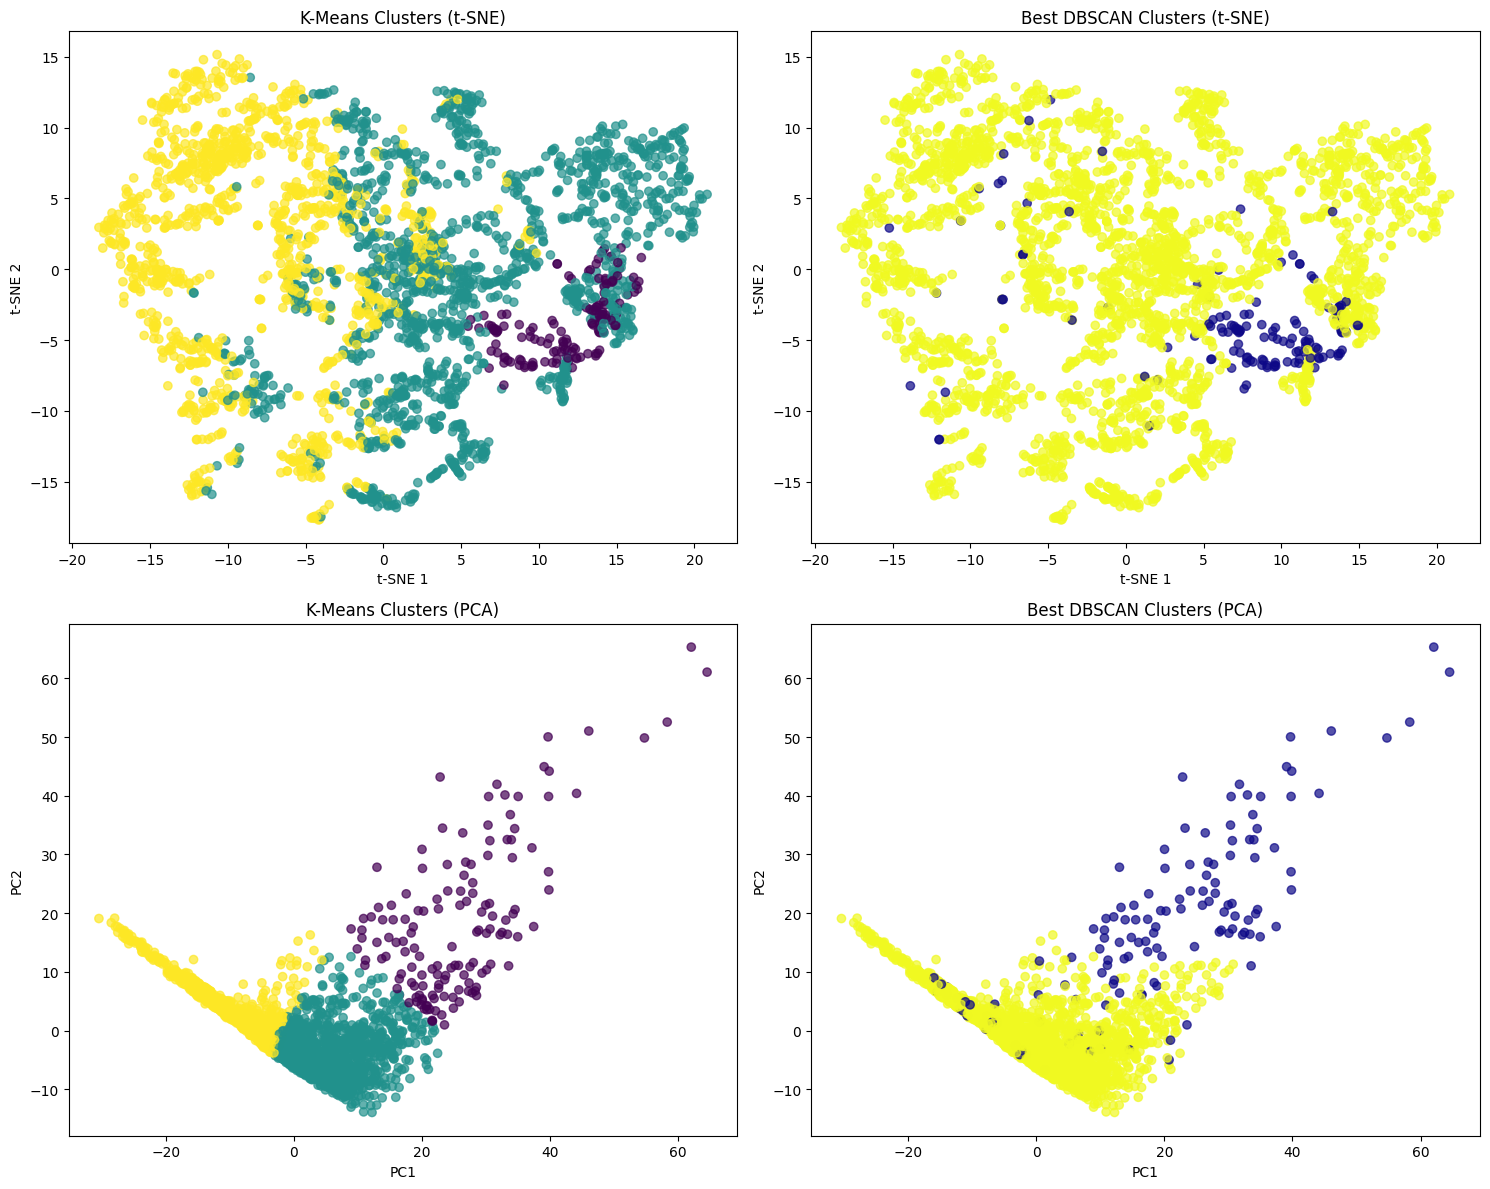

In [128]:
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
print(f"Best DBSCAN - Silhouette Score: {best_dbscan_silhouette:.4f}, Davies-Bouldin Index: {best_dbscan_db_index:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# K-Means Clusters on t-SNE
axes[0, 0].scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('K-Means Clusters (t-SNE)')
axes[0, 0].set_xlabel('t-SNE 1')
axes[0, 0].set_ylabel('t-SNE 2')

# Best DBSCAN Clusters on t-SNE
axes[0, 1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=best_dbscan_labels, cmap='plasma', alpha=0.7)
axes[0, 1].set_title('Best DBSCAN Clusters (t-SNE)')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')

# K-Means Clusters on PCA
axes[1, 0].scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[1, 0].set_title('K-Means Clusters (PCA)')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')

# Best DBSCAN Clusters on PCA
axes[1, 1].scatter(features_pca[:, 0], features_pca[:, 1], c=best_dbscan_labels, cmap='plasma', alpha=0.7)
axes[1, 1].set_title('Best DBSCAN Clusters (PCA)')
axes[1, 1].set_xlabel('PC1')
axes[1, 1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

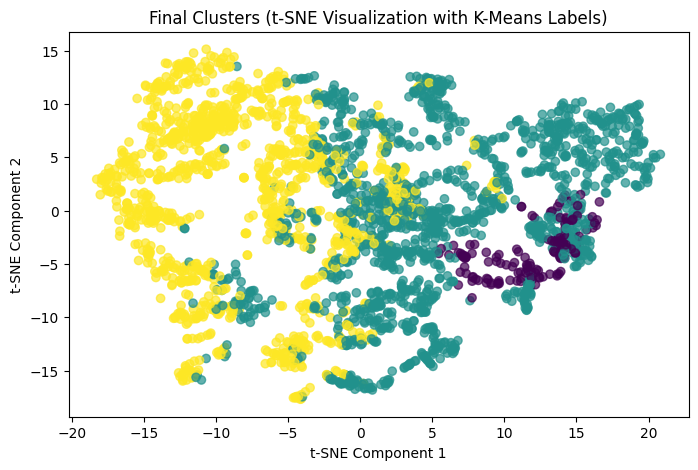

In [129]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.

When i tried to visualize without dimensionality reduction, i got scatter plots that were hard to read. And some feature patterns cannot easily spot them with the naked eye.

By going to performing the technique and having fewer dimensions, I have a fighting change figuring out what can and cannot be clusterd. And then i could finaly use the algorithms to cluster.

- Justify why certain clustering methods worked better.

DBSCAN may start off failing without any tuning. But once optimized, it performed the best. I think it is better for more complex clustering issues when the data is dynamic.

Kmeans on the other hand is good at finding clusters if the k is still small and using the elbow methods can easily pick main groups with ease. But it's scores (like Silhouette score) show it isn't great at clustering overall.

- Relate findings to real-world clustering challenges.

Picking the right method depending on tasks: you can experiment depending on your data and find which is best for your clustering project and do final fine tuning instead of trying to only stick to one method.

Reducing dimensions is crucial, but has to be done effectively. Hence using the right technique for the job will make life easier and save computational resources while dealing with the most important dimension of the data and ignoring the noise or less important features.

# Summary:

### Data Analysis Key Findings

*   The best DBSCAN parameters found were `eps=9.5` and `min_samples=6`.
*   With the best parameters, DBSCAN achieved a Silhouette score of 0.4273 and a Davies-Bouldin index of 1.4040.
*   K-Means had a Silhouette score of 0.2001 and a Davies-Bouldin index of 1.4804.
*   The best DBSCAN had a higher Silhouette score and a lower Davies-Bouldin index compared to K-Means.

### Insights

*   Based on the evaluation scores, DBSCAN with the optimized parameters appears to provide a better clustering solution for this dataset compared to K-Means.
*   Visual inspection of the cluster plots on the reduced data confirms that DBSCAN creates more distinct and potentially meaningful clusters than K-Means, which shows less separation.


# Summary:

### Data Analysis Key Findings

*   The best DBSCAN parameters found were `eps=9.5` and `min_samples=6`.
*   With the best parameters, DBSCAN achieved a Silhouette score of 0.4273 and a Davies-Bouldin index of 1.4040.
*   K-Means had a Silhouette score of 0.2001 and a Davies-Bouldin index of 1.4804.
*   The best DBSCAN had a higher Silhouette score and a lower Davies-Bouldin index compared to K-Means.

### Insights or Next Steps

*   Based on the evaluation scores, DBSCAN with the optimized parameters appears to provide a better clustering solution for this dataset compared to K-Means.
*   Visual inspection of the cluster plots on the reduced data confirms that DBSCAN creates more distinct and potentially meaningful clusters than K-Means, which shows less separation.
